# Thompson sampling on ads CTR problem
In this notebook we implemented Thomposon sampling to detect which ad has the highest CTR (click-through rate). 

This is a classic version of Bernoulli multi arm bandit (MAB) problem. The agent in our case doesn't know the real CTR of each ad. We use Thompson sampling to deal with the exploration-exploitation dilemma in the multi-armed bandit problem. For our use in the Thompson Sampling algorithm, we will generate random points from Beta distribution.
This distribution is a family of continuous probability distributions defined on the interval [0, 1]. 
The Beta distribution is defined by 2 parameters, denoted by 𝛼 (representing the Hits) and 𝛽 (representing the misses). The intuition behind this choice derived from the density of this distribution around (0,1).


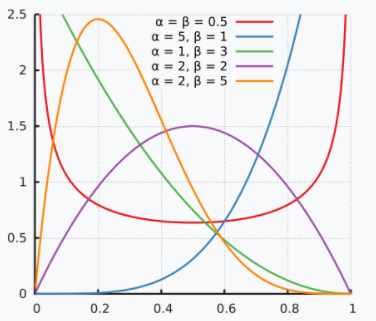

#**Bayesian V.S Frequentist Approaches**

We use Bayesian approach in Thompson Sampling so let's explain a little about the Bayesian approach.


###What is probability?

**Bayesian Approach**: Subjective degree of belief

**Frequentist Approach**:Limiting frequency

###What is the goal?
**Bayesian Goal**: Quantify and analyze subjective degrees of belief

**Frequentist Goal**:Create procedures that have frequency guarantees



### The Bayesian method

Bayesian inference is usually carried out in the following way:

**Step 1**:We choose a probability density - called the prior distribution π(θ)  that expresses our beliefs about a parameter before we see any data.

**Step 2**:We choose a statistical model f(x|θ) that reflects our beliefs about x given θ. Notice that we now write this as f(x|θ) instead of f(x;θ).

**Step 3**:After observing data x  we update our beliefs and calculate the posterior distribution f(θ|x)  that reflects our updated beliefs about θ given x. 



#**Thompson V.S UCB**
In UCB algorithms - the method is bounding the regret by a function that consider the history, and apply an explore-exploit policy. 

For example - UCB-1 chooses in each iteration the arm that maximize:

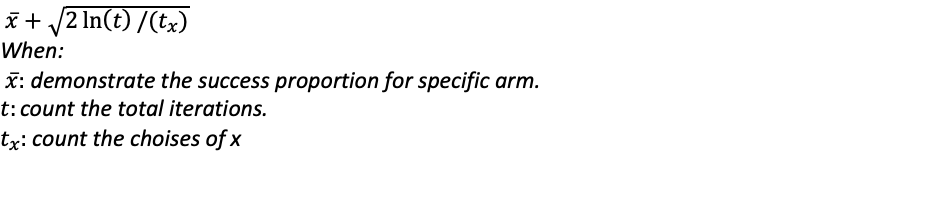

An interesting difference between these 2 methods is that the target function in UCB isn't in use in TS at all. Whereas this function and the upper bound definition has impact on the UCB results (different bounds -> different results), TS choose only by the performance of the arms. In situations of difficult dependencies - it is a major advantage for TS.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In this data set we have 10,000 users and 10 ads. The natural thing is to work on enviroment and not a data set in this kind of problem (RL), but for the Bernoulli multi arm bandit problem we can work on data set too.

In [ ]:
df = pd.read_csv("Ads_CTR_Optimisation.csv")
df.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In this graph you can see the actual distribution of the data. This data will be hidden for the agent in MAB problem. You can see that ad 5 has the highest CTR so we want that the agent will find this out as quick as possible. 

Ad 1     0.1703
Ad 2     0.1295
Ad 3     0.0728
Ad 4     0.1196
Ad 5     0.2695
Ad 6     0.0126
Ad 7     0.1112
Ad 8     0.2091
Ad 9     0.0952
Ad 10    0.0489
dtype: float64


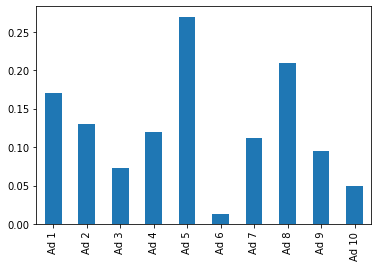

In [ ]:
total = len(df)
per = df.sum(axis=0)/total
per.plot.bar()
print(per)

We implemented the Bernoulli version for Thompson sampling from the paper "A Tutorial on Thompson Sampling" by Daniel J. Russo.

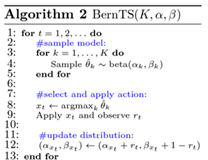



###What is Thompson Sampling?

It was originally described by Thompson in 1933, and has been improved many times over the years. Thompson sampling,named after William R. Thompson, is a heuristic for choosing actions that addresses the exploration-exploitation dilemma in the multi-armed bandit problem. It consists of choosing the action that maximizes the expected reward with respect to a randomly drawn belief.


###Relationship Between Thompson Sampling & Bayesian Inference

Thompson Sampling algorithm will update some values after analyzing each data row. Since it will be an analysis with continuous updating, Thompson Sampling is dynamic, which is why the Bayesian approach is applied in Thompson Sampling.

In Bayesian terms our initial estimate is known as the prior probability and, after seeing some data and refining this estimate, we form the posterior probability. When both the prior and posterior have the same type of probability distribution they are said to be conjugate distributions. Additionally, when this happens, the prior is said to be the conjugate prior of the likelihood distribution (which can be thought of as the actual distribution of the data).



We’ll define regret as the difference between the highest possible CTR and the CTR shown. For example, if ad A has a known CTR or 0.1 and ad B has a known CTR of 0.3, each time we show ad A, we have a regret equal to 0.3 - 0.1 = 0.2.

In [ ]:
def TS(df):
  T = 10000
  K = 10
  actions = []
  reward = 0
  regret = []
  theta = [0 for i in range(K)]
  alpha = [1 for i in range(K)]
  beta = [1 for i in range(K)]
  for i in range(T):
    sampling = {x:0 for x in range(K)}
    for j in range(K):
      sampling[j] = np.random.beta(alpha[j], beta[j])
    action = max(sampling, key=sampling.get)
    if df.iloc[i].iloc[action] == 1:
      reward +=1
      alpha[action] +=1 
    else:
      beta[action] +=1
    regret.append(df.iloc[i].iloc[4]-df.iloc[i].iloc[action])
    actions.append(action)
  return regret, actions,reward


We show the average regret on 1000 iterations. you can see on the graph that the regret is converge to 0 quickly as expected.

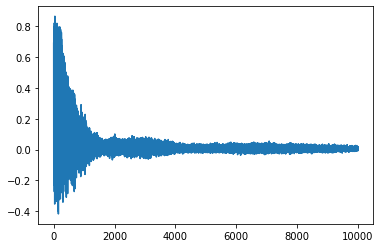

In [ ]:
total_regret = [0 for i in range(10000)]
for i in range(1000):
  tmp, _, _ = TS(df)
  for i in range(10000):
    total_regret[i] += tmp[i]
average = [i/1000 for i in total_regret]
plt.plot(range(10000), average)

#**UCB1**

The algorithm UCB1 [Auer et al.(2002)] is an algorithm for the multi-armed bandit that achieves regret that grows only logarithmically with the number of actions taken.

For each action j record the average reward xj and number of times we have tried it tj. We write t for total number of actions we have tried.

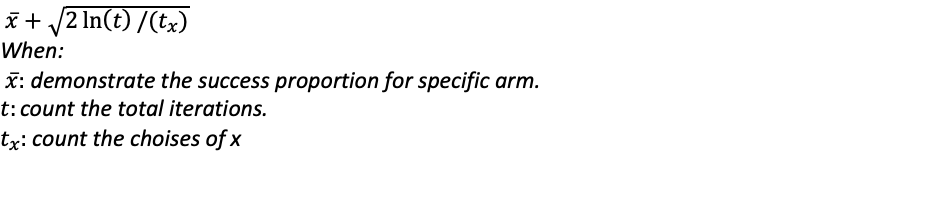


In [ ]:
def average(list):
  return sum(list)/len(list)

In [ ]:
def val(lst, t):
  return average(lst) + (2*np.log(t)/len(lst))**0.5

In [ ]:
def UCB1(df):
  T = len(df)
  K = 10
  value = {x:[1] for x in range(K)}
  actions = []
  reward = 0
  regret = []
  for i in range(T):
    sampling = {x:val(value[x], i+1) for x in range(K)}
    action = max(sampling, key=sampling.get)
    if df.iloc[i].iloc[action] == 1:
      reward +=1
      value[action].append(1)
    else:
      value[action].append(0)
    regret.append(df.iloc[i].iloc[4]-df.iloc[i].iloc[action])
    actions.append(action)
  return regret, actions, reward

In [ ]:
regret,act, reward = UCB1(df)

*Note: We numerated the ads 0-9 (instead of 1-10) so the best ad in the new numbers is 4.

The histogram shows the actions chosen by the UCB1 algorithm. The algorithm performs well and it realizes that ad number 4 is the best ad.

the reward and the actions of UCB1:

2158


(array([ 780.,  394.,  279.,  375., 5952.,  189.,  478., 1003.,  333.,
         217.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

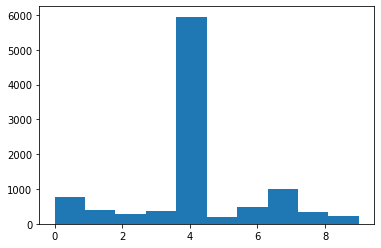

In [ ]:
print(reward)
plt.hist(act)

In [ ]:
regret, actions, reword = TS(df)

This histogram below shows the actions chosen by the Thompson Sampling algorithm. The algorithm performs well and it realizes that ad number 4 is the best ad.
We can see that the other actions bar is much lower than in the previous chart. The TS algorithm chooses the best action more times.
TS wastes less effort for useless exploration. As a consequence it gets better rewards.

2599


(array([ 133.,   96.,   59.,  119., 9343.,   25.,   33.,  115.,   46.,
          31.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

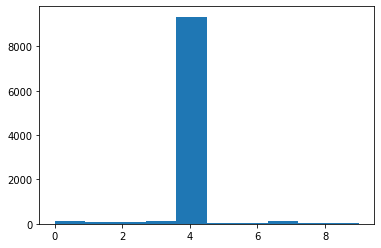

In [ ]:
print(reword)
plt.hist(actions)

We can see that TS converage faster than UCB1 to the best ad and achive better reward in this case. This finding supports the article claim that Thompson sampling is converging very fast to 0 regret compaire to the other methods in many cases.